In [1]:
import os.path

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import defaultdict
import time
import matplotlib.pyplot as plt

from args import *
from utils import *
from model import *

In [2]:
class Args:
    def __init__(self):
        self.dataset = 'phone-email'
        self.ratio = 0.2
        self.use_attr = False
        self.device = 'cpu'
        self.model = 'BRIGHT'
        self.num_layers = 1
        self.hidden_dim = 128
        self.out_dim = 128
        self.lambda_w = 1
        self.lambda_edge = 0
        self.lambda_total = 1e-2
        self.in_iter = 5
        self.out_iter = 10
        self.lr = 1e-3
        self.epochs = 50

In [3]:
args = Args()
# check compatibility between dataset and use_attr
if args.dataset == 'noisy-cora1-cora2':
    assert args.use_attr is True, 'noisy-cora1-cora2 requires using node attributes'
elif args.dataset == 'foursquare-twitter' or args.dataset == 'phone-email':
    assert args.use_attr is False, f'{args.dataset} does not have node attributes'

# load data and build networkx graphs
np_dtype = np.float64
torch_dtype = torch.float64
print("Loading data...", end=" ")
edge_index1, edge_index2, x1, x2, anchor_links, test_pairs = load_data(f"datasets/{args.dataset}", args.ratio,
                                                                       args.use_attr, dtype=np_dtype)
anchor1, anchor2 = anchor_links[:, 0], anchor_links[:, 1]
G1, G2 = build_nx_graph(edge_index1, anchor1, x1), build_nx_graph(edge_index2, anchor2, x2)
print("Done")

rwr1, rwr2 = get_rwr_matrix(G1, G2, anchor_links, args.dataset, args.ratio, dtype=np_dtype)
if x1 is None:
    x1 = rwr1
if x2 is None:
    x2 = rwr2

# device setting
assert torch.cuda.is_available() or args.device == 'cpu', 'CUDA is not available'
device = torch.device(args.device)
torch.set_default_dtype(torch.float64)

# build PyG Data objects
G1_tg = build_tg_graph(edge_index1, x1, rwr1, dtype=torch_dtype).to(device)
G2_tg = build_tg_graph(edge_index2, x2, rwr2, dtype=torch_dtype).to(device)

# model setting
input_dim = G1_tg.x.shape[1]
hidden_dim = args.hidden_dim
output_dim = args.out_dim

Loading data... Done
Loading RWR scores from datasets/rwr/rwr_emb_phone-email_0.2.npz... Done


In [48]:
model = BRIGHT(input_dim=input_dim, hidden_dim=output_dim, output_dim=output_dim).to(device)
if args.model == 'PGNA':
    model = PGNA(input_dim=input_dim,
                 feature_dim=output_dim,
                 anchor_dim=anchor_links.shape[0],
                 hidden_dim=output_dim,
                 output_dim=output_dim,
                 num_layers=args.num_layers).to(device)
elif args.model == 'RWRNet':
    model = RWRNet(num_layers=args.num_layers,
                   input_dim=input_dim,
                   output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = FusedGWLoss(G1_tg, G2_tg, anchor1, anchor2,
                        lambda_w=args.lambda_w,
                        lambda_edge=args.lambda_edge,
                        lambda_total=args.lambda_total,
                        in_iter=args.in_iter,
                        out_iter=args.out_iter).to(device)
scheduler = CosineAnnealingLR(optimizer, T_max=args.epochs)
epoch = 0

In [66]:
r1 = G1_tg.rwr / torch.linalg.norm(G1_tg.rwr, ord=2, dim=1, keepdim=True)
r2 = G2_tg.rwr / torch.linalg.norm(G2_tg.rwr, ord=2, dim=1, keepdim=True)
crossC = torch.exp(-r1 @ r2.T)
rank_cross_row = torch.argsort(crossC, dim=1)
rank_cross_col = torch.argsort(crossC, dim=0)
print(rank_cross_row)
print(rank_cross_col)

tensor([[  0, 631, 888,  ..., 854, 212,  99],
        [  1, 705, 162,  ..., 854,  99,   0],
        [296, 877, 718,  ..., 669, 396, 854],
        ...,
        [997, 682, 550,  ..., 575, 854, 340],
        [296, 877, 718,  ..., 396, 854,   0],
        [503, 999,  17,  ...,   0, 396, 854]])
tensor([[  0,   1, 529,  ..., 889, 889, 889],
        [383, 970, 408,  ..., 555, 555, 555],
        [290, 155, 998,  ..., 206, 206, 206],
        ...,
        [ 99, 898, 471,  ..., 863, 863, 863],
        [952, 952,   0,  ..., 898, 898, 898],
        [589,   0, 898,  ...,   0,   0,   0]])


In [73]:
crossC[2, 296]

tensor(0.3882)

In [76]:
rank_cross_col[:100, 296]

tensor([770, 296, 432, 264, 551, 511, 365, 657, 868, 690, 614, 830, 701, 184,
        363, 160, 904, 531, 265, 877, 998,  53, 334, 875, 719, 441, 292, 408,
        438, 765, 321, 588, 594, 718, 476, 306, 404, 391, 293, 454, 843, 498,
        165, 981, 101, 895, 798, 529, 364, 344, 458, 776, 564, 505, 274, 163,
        254, 672, 161, 145, 126, 235, 837, 647, 516, 452, 945, 766,   2, 959,
        947, 103, 418, 297, 587, 357, 788, 372, 991, 302, 668, 106, 942, 862,
        420, 562, 156, 827, 320, 202, 799, 939, 601, 650, 567, 805, 999,  88,
         26, 737])

In [78]:
crossC[296, 296]

tensor(0.3785)

In [49]:
model.train()
start = time.time()
optimizer.zero_grad()
out1, out2 = model(G1_tg, G2_tg)
loss = criterion(out1=out1, out2=out2)
loss.backward()
optimizer.step()
print(f'Epoch {epoch + 1}, Loss: {loss.item():.6f}', end=', ')

# testing
with torch.no_grad():
    model.eval()
    inter_c = torch.exp(-(out1 @ out2.T))
    intra_c1, intra_c2 = criterion.intra_c1, criterion.intra_c2
    similarity = sinkhorn(inter_c, intra_c1, intra_c2,
                          lambda_w=args.lambda_w,
                          lambda_e=args.lambda_edge,
                          lambda_t=args.lambda_total,
                          in_iter=args.in_iter,
                          out_iter=args.out_iter,
                          device=device)
    hits, mrr = compute_metrics(-similarity, test_pairs)
    cost = inter_c / inter_c.sum()
    cost_entropy = torch.sum(-cost * torch.log(cost))
    s_entropy = torch.sum(-similarity * torch.log(similarity))
    end = time.time()
    print(f'cost_entropy: {cost_entropy:.6f}, s_entropy: {s_entropy:.6f}, '
          f'{", ".join([f"Hits@{key}: {value:.4f}" for (key, value) in hits.items()])}, MRR: {mrr:.4f}')
    epoch += 1

Epoch 1, Loss: -0.370018, cost_entropy: 13.818481, s_entropy: 13.818087, Hits@1: 0.0000, Hits@5: 0.0025, Hits@10: 0.0138, Hits@30: 0.1875, Hits@50: 0.4437, Hits@100: 0.8525, MRR: 0.0231


In [54]:
with torch.no_grad():
    print(f'{inter_c[0, 0]:.16f}')
    print(f'{1/torch.exp(torch.tensor(1)):.16f}')
    rank_c_row = torch.argsort(inter_c, dim=1)
    rank_c_col = torch.argsort(inter_c, dim=0)
    rank = torch.argsort(-similarity, dim=1)
    print(rank[:10, :5])
    print(torch.where(rank_c_row[0, :] == rank[0, 1]), torch.where(rank_c_row[0, :] == rank[0, 2]))
    print(torch.where(rank_c_row[2, :] == rank[2, 0]), torch.where(rank_c_row[2, :] == rank[2, 1]))
    print(torch.where(rank_c_row[3, :] == rank[3, 0]), torch.where(rank_c_row[3, :] == rank[3, 1]))

0.3679003101137131
0.3678794411714423
tensor([[  0, 631, 860, 102, 890],
        [  1, 215, 742,  60, 720],
        [317, 267, 568, 141, 818],
        [581,  40, 107,  89,  14],
        [  4, 606, 215, 925,   1],
        [852, 203, 439, 283, 992],
        [203, 852, 439, 992, 283],
        [603, 758, 902,  47, 761],
        [  8, 980, 852, 760, 150],
        [876, 845,  83, 416, 574]])
(tensor([1]),) (tensor([803]),)
(tensor([910]),) (tensor([842]),)
(tensor([983]),) (tensor([916]),)


Dist: 0.00000000000000000000


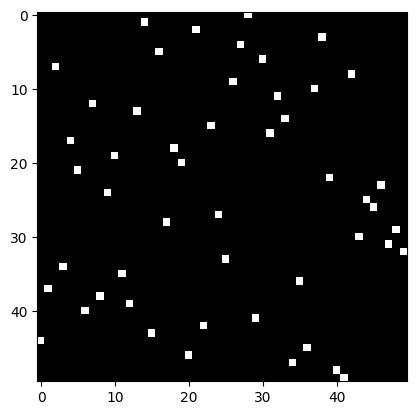

In [7]:
# Test Sinkhorn
nx, ny = 50, 50
crossC = torch.ones(nx, ny).to(torch.float64)
crossC[torch.randperm(nx), torch.randperm(ny)] = 0
intraC1 = torch.rand(nx, ny).to(torch.float64)
intraC2 = torch.rand(nx, ny).to(torch.float64)
S = sinkhorn(crossC, intraC1, intraC2, lambda_w=1, lambda_e=0, lambda_t=1e-2, in_iter=10, out_iter=100)
plt.imshow(S, cmap='gray')
print('Dist: %.20f' % torch.sum(crossC * S)) 

In [94]:
n = 5
for i in range(100000):
    av = torch.rand(n)
    bv = torch.rand(n)
    av /= -torch.linalg.norm(av, ord=2)
    bv /= -torch.linalg.norm(bv, ord=2)
    s = torch.sum(av * bv)
    if s < -1 or s > 1:
        print('error')